In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [3]:

# 1. Load and prepare the data
# Download the dataset
df = pd.read_csv("https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip")
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


In [4]:
# Using a subset for faster training
df = df[5::6] # Use data every hour instead of every 10 mins
df.set_index('Date Time', inplace=True)

# Select features and the target
features_to_use = ['p (mbar)', 'T (degC)', 'rh (%)']
target_feature = 'T (degC)'

features = df[features_to_use]
# Standardize the features
features = (features - features.mean()) / features.std()

In [5]:
# --- Preprocessing Function ---
def multivariate_windowed_dataset(features, target, start_index, end_index, history_size,
                                 target_size, step, single_step=False):
    """Creates windowed data for multi-feature time series."""
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(features) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(features.iloc[indices].values)
        if single_step:
            labels.append(target.iloc[i + target_size])
        else:
            labels.append(target.iloc[i:i + target_size].values)
    return np.array(data), np.array(labels)

# --- Parameters ---
past_history = 120  # 5 days of data (120 hours)
future_target = 24  # Predict 24 hours into the future
STEP = 1
split_fraction = 0.8
train_split = int(split_fraction * len(features))

# --- Create Training and Validation Datasets ---
x_train, y_train = multivariate_windowed_dataset(
    features=features,
    target=features[target_feature],
    start_index=0,
    end_index=train_split,
    history_size=past_history,
    target_size=future_target,
    step=STEP,
    single_step=True)

x_val, y_val = multivariate_windowed_dataset(
    features=features,
    target=features[target_feature],
    start_index=train_split,
    end_index=None,
    history_size=past_history,
    target_size=future_target,
    step=STEP,
    single_step=True)

# --- Create TensorFlow datasets ---
batch_size = 256
buffer_size = 10000

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).prefetch(1)

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.batch(batch_size).prefetch(1)

In [21]:
x_train.shape

(55952, 120, 3)

In [22]:
# 2. Build the CNN Model
# Input shape is (history_size, num_features)
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=x_train.shape[-2:]),
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 116, 32)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 58, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 56, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 28, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │        28,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,425 (138.38 KB)

 Trainable params: 35,425 (138.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# prompt: plot the model

tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, dpi=80)


In [18]:
# 3. Compile and Train the Model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [19]:
history = model.fit(
    train_data,
    epochs=2,
    validation_data=val_data,
    verbose=1)

Epoch 1/2
219/219 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - loss: 0.2658 - mae: 0.3965 - val_loss: 0.1714 - val_mae: 0.3274
Epoch 2/2
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - loss: 0.1560 - mae: 0.3108 - val_loss: 0.1505 - val_mae: 0.3067


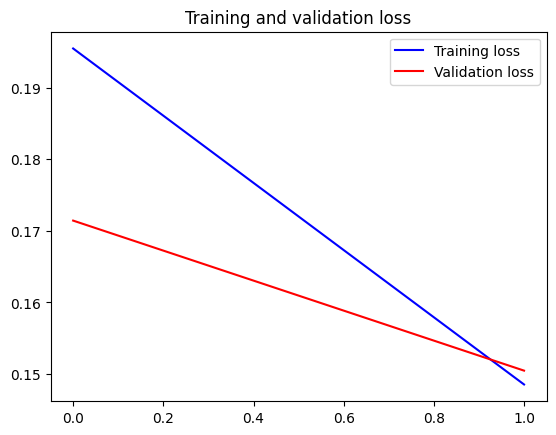

In [20]:
# prompt: plot loss

import matplotlib.pyplot as plt
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()


plot_train_history(history, 'Training and validation loss')